In [1]:
import numpy as np
import xarray as xr
import scipy
from scipy import stats
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import os

In [76]:
#Load data
cFlx = xr.open_mfdataset(sorted(glob('/Users/marki/Downloads/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_allsky_clearsky.nc')))
cldtypes = ['Cu','Sc','St','Ac','As','Ns','Ci','Cs', 'Cb']
dFlx = {} #Each cloud type aggregated separately
for cldtype in cldtypes:
    dFlx[cldtype] = xr.open_dataset('/Users/marki/Downloads/%s_climo_mon.nc' % cldtype)
   # print(dFlx[cldtype]['toa_albedo_cldtyp_mon'].shape)
syn = xr.open_mfdataset(sorted(glob('/Users/marki/Downloads/CERES_SSF1deg-Month_Aqua-MODIS_Ed4.1_Subset_200207-202203.nc')))
colors = {'Cu' : cm.Blues(.25), 'Sc' : cm.Blues(.5), 'St' : cm.Blues(.75), 'Ac' : cm.Purples(.25), 'As' : cm.Purples(.5), 'Ns' : cm.Purples(.75), 'Ci' : cm.Reds(.25), 'Cs' : cm.Reds(.5), 'Cb' : cm.Reds(.75),'all' : '.5'}

CRE={'SW' : cm.Blues(.5), 'LW' : cm.Purples(.5), 'Net' : cm.Reds(.5)}


In [77]:
def get_CRE_Sw_binned(ct,bin_width=.1):
    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
    F_cld_sw=np.ravel(dFlx[ct]['toa_sw_cldtyp_mon' ][:,30:150,:])
    F_clr_sw=np.ravel(cFlx['toa_sw_clr_mon'][:,30:150,:])
    
    CRE_sw= -CF_*(F_cld_sw-F_clr_sw)
    
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(CRE_sw))
    valid = np.logical_and(ocn,~nan)
    
    CF=CF_[valid]
    CRE_SW=CRE_sw[valid]
    
    Cbinc = np.arange(bin_width/2,1,bin_width)
    CRE_SW_binned = [(CRE_SW[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, CRE_SW_binned, CF, CRE_SW

def get_CRE_Lw_binned(ct,bin_width=.1):
    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
    F_cld_lw=np.ravel(dFlx[ct]['toa_lw_cldtyp_mon' ][:,30:150,:])
    F_clr_lw=np.ravel(cFlx['toa_lw_clr_mon'][:,30:150,:])
    
    CRE_lw= -CF_*(F_cld_lw-F_clr_lw)
    
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(CRE_lw))
    valid = np.logical_and(ocn,~nan)
    
    CF=CF_[valid]
    CRE_LW=CRE_lw[valid]
    
    Cbinc = np.arange(bin_width/2,1,bin_width)
    CRE_LW_binned = [(CRE_LW[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, CRE_LW_binned, CF, CRE_LW

def get_CREnet_binned(ct,bin_width=.1):
    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
    F_cld_lw=np.ravel(dFlx[ct]['toa_lw_cldtyp_mon' ][:,30:150,:])
    F_clr_lw=np.ravel(cFlx['toa_lw_clr_mon'][:,30:150,:])
    F_cld_sw=np.ravel(dFlx[ct]['toa_sw_cldtyp_mon' ][:,30:150,:])
    F_clr_sw=np.ravel(cFlx['toa_sw_clr_mon'][:,30:150,:])
    F_in_sw= np.ravel(cFlx['toa_solar_all_mon'][:,30:150,:])
    
    CREnet=-CF_*(F_cld_sw-F_clr_sw+F_cld_lw-F_clr_lw)
    
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(CREnet))
    valid = np.logical_and(ocn,~nan)
    
    CF=CF_[valid]
    CRE_net=CREnet[valid]
    
    Cbinc = np.arange(bin_width/2,1,bin_width)
    CRE_net_binned = [(CRE_net[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, CRE_net_binned, CF, CRE_net

In [78]:
def graphs(ct,bin_width=.05, save=False):
   #Longwave CRE Data
    Cbinc, CRE_LW_binned, CF, CRE_LW=get_CRE_Lw_binned(ct,bin_width)
    
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(CRE_LW_binned)):
        if len(CRE_LW_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(CRE_LW_binned[i]))
            emin.append(np.percentile(CRE_LW_binned[i],25))
            emax.append(np.percentile(CRE_LW_binned[i],75))
            N.append(len(CRE_LW_binned[i]))
    LW_centers = np.array(centers)
    LW_means = np.array(means)
    LW_emin = np.array(emin)
    LW_emax = np.array(emax)
    LW_N = np.array(N)
    
    #Shortwave CRE Data
    Cbinc, CRE_SW_binned, CF, CRE_SW=get_CRE_Sw_binned(ct,bin_width)
    
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(CRE_SW_binned)):
        if len(CRE_LW_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(CRE_SW_binned[i]))
            emin.append(np.percentile(CRE_SW_binned[i],25))
            emax.append(np.percentile(CRE_SW_binned[i],75))
            N.append(len(CRE_SW_binned[i]))
    SW_centers = np.array(centers)
    SW_means = np.array(means)
    SW_emin = np.array(emin)
    SW_emax = np.array(emax)
    SW_N = np.array(N)
    
    #Net CRE Data
    Cbinc, CRE_net_binned, CF, CRE_net=get_CREnet_binned(ct,bin_width)
    
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(CRE_net_binned)):
        if len(CRE_net_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(CRE_net_binned[i]))
            emin.append(np.percentile(CRE_net_binned[i],25))
            emax.append(np.percentile(CRE_net_binned[i],75))
            N.append(len(CRE_net_binned[i]))
    net_centers = np.array(centers)
    net_means = np.array(means)
    net_emin = np.array(emin)
    net_emax = np.array(emax)
    net_N = np.array(N)

    #Plot data
    plt.figure(figsize=(12,10))
    plt.clf()
    fs = 20

    SW=plt.scatter(SW_centers,SW_means,s=SW_N/1000,facecolor=CRE['SW'],edgecolors='k',lw=1)
    plt.errorbar(SW_centers,SW_means,yerr=np.array((SW_means-SW_emin,SW_emax-SW_means)),color='b',lw=2,fmt='none',capsize=4)

    LW=plt.scatter(LW_centers,LW_means,s=LW_N/1000,facecolor=CRE['LW'],edgecolors='k',lw=1)
    plt.errorbar(LW_centers,LW_means,yerr=np.array((LW_means-LW_emin,LW_emax-LW_means)),color='k',lw=2,fmt='none',capsize=4)
    
    NET=plt.scatter(net_centers,net_means,s=net_N/1000,facecolor=CRE['Net'],edgecolors='k',lw=1)
    plt.errorbar(net_centers,net_means,yerr=np.array((net_means-net_emin,net_emax-net_means)),color='r',lw=2,fmt='none',capsize=4)
    
    plt.yticks(fontsize=fs-2)
    plt.ylabel('SW, LW, and Net cloud radiative effect',fontsize=fs)
    plt.xticks(fontsize=fs-2)
    plt.xlabel('%s cloud fraction' % ct,fontsize=fs)
    plt.xlim(0,1)
    plt.legend([SW,LW,NET],['SWCRE=Shortwave CRE', 'LWCRE= Longwave CRE', 'CRE= Net CRE'],loc='best' , title='Cloud Radiative Effect Type',markerscale=.6,handletextpad=2 ,labelspacing=2, edgecolor='k', frameon=True,  borderpad=1 )
    plt.title(ct,fontsize=fs+4)


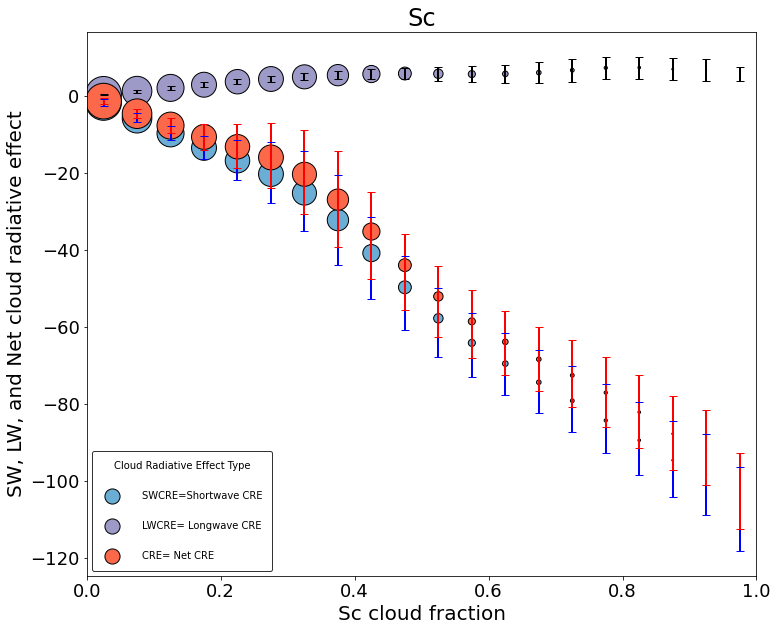

In [79]:
graphs('Sc')

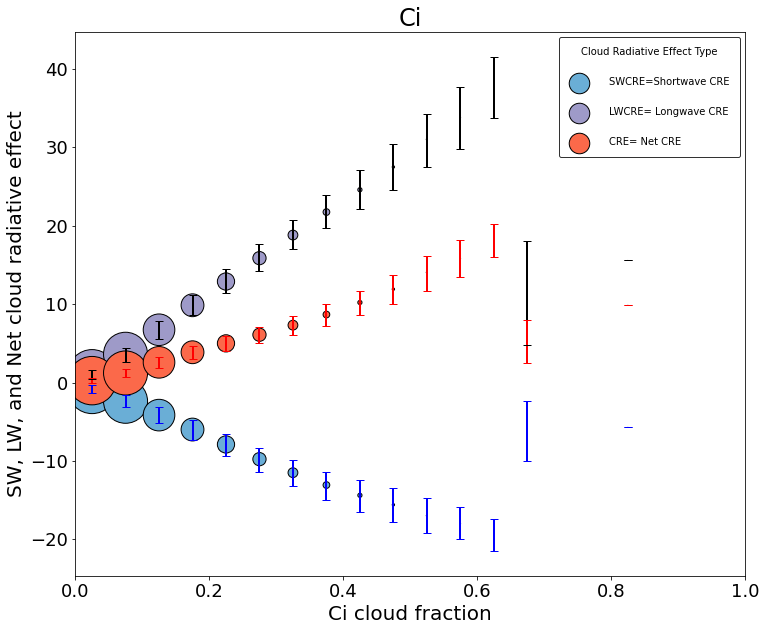

In [80]:
graphs('Ci')

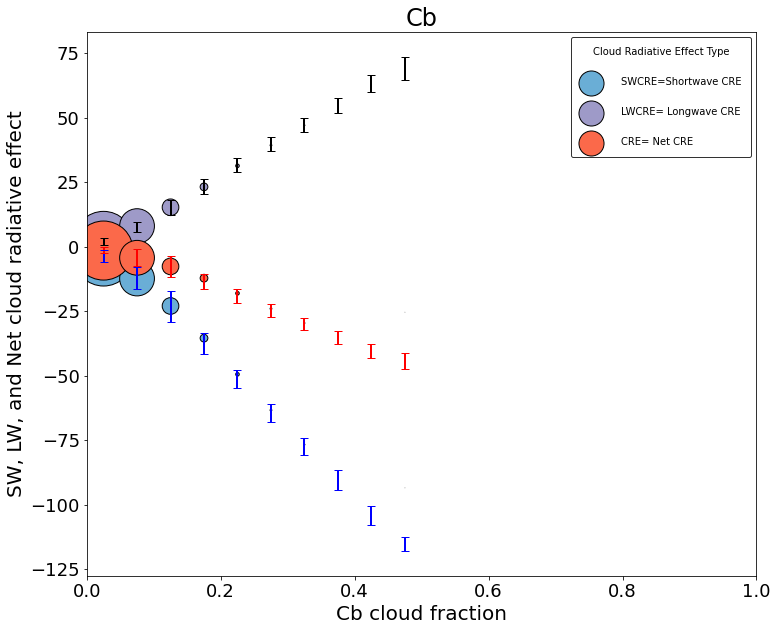

In [81]:
graphs('Cb')

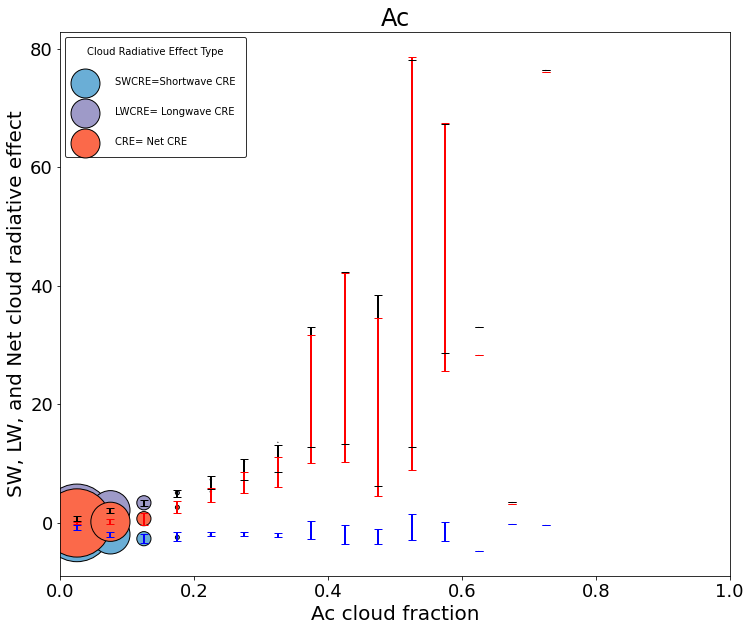

In [82]:
graphs('Ac')

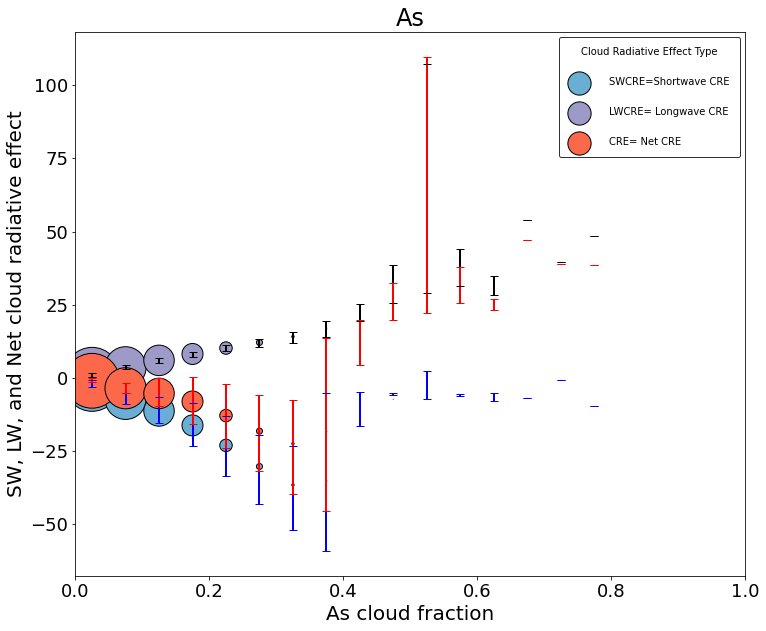

In [83]:
graphs('As')

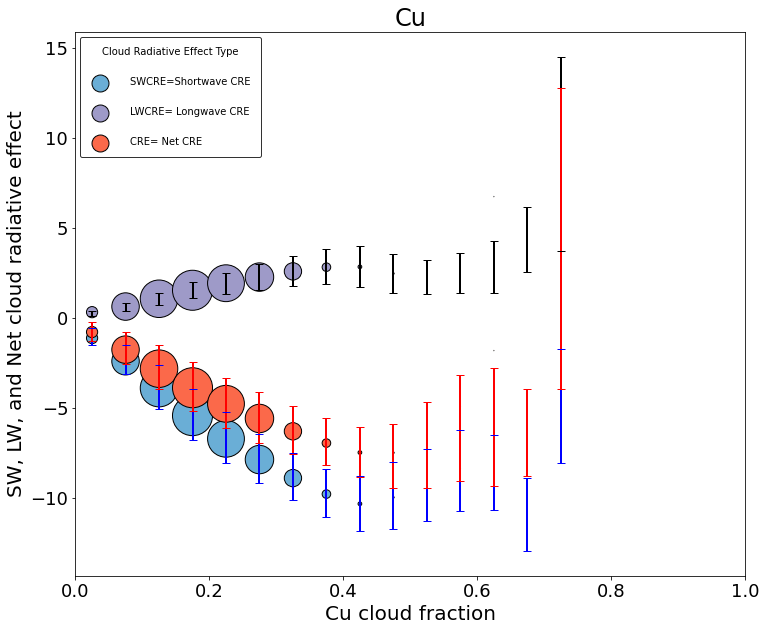

In [84]:
graphs('Cu')

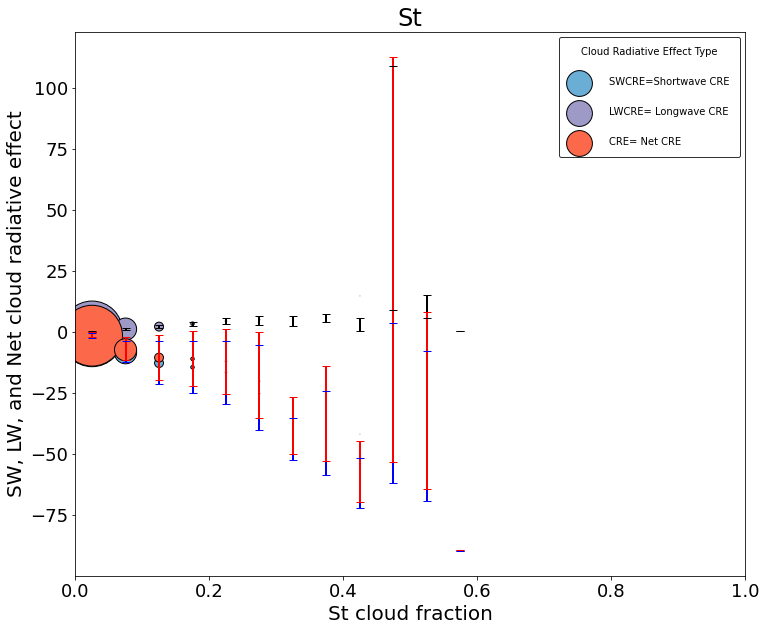

In [85]:
graphs('St')

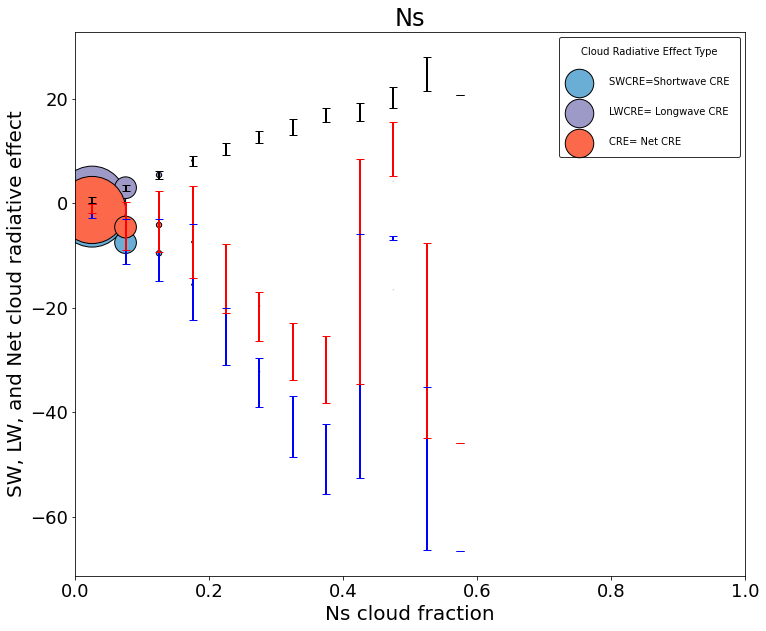

In [86]:
graphs('Ns')

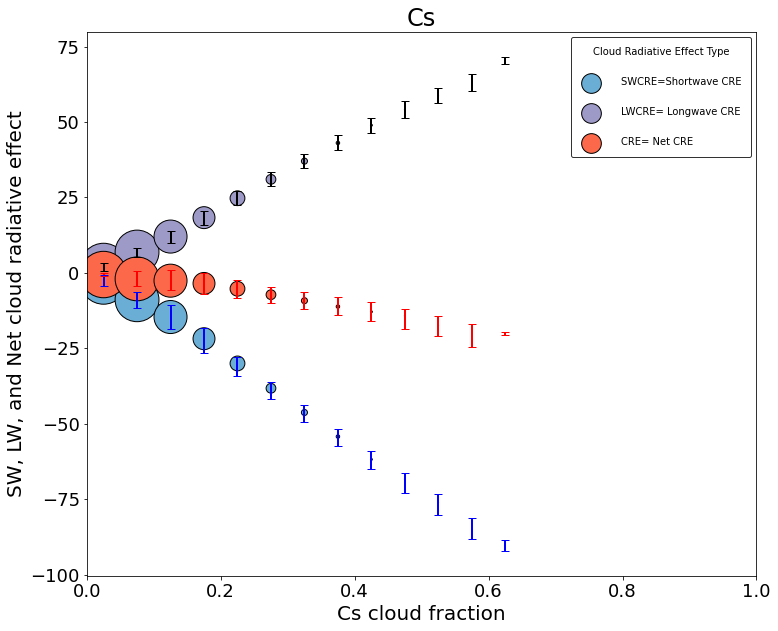

In [87]:
graphs('Cs')